# Spatial integration of the mouse cortex

Mouse brain cortex **10x Visium** data: https://satijalab.org/seurat/articles/spatial_vignette \
Mouse brain cortex **Drop-seq** data: http://dropviz.org/ \
Mouse brain cortex **snmC-seq** data: https://brainome.ucsd.edu/annoj/brain_single_nuclei/

## Import

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import random
import os
import matplotlib.pyplot as plt
import simo
from simo import load_data, process_anndata, find_marker, alignment_1_batch, assign_coord_1, alignment_2, assign_coord_2ew
from simo.regulation import regulation_analysis, spatial_regulation
from simo import sdplot, sfplot, cor_plot, module_vilolin_plot, module_dot_plot, module_pca_plot, module_spatial_plot, module_heatmap_plot, plot_3d

import warnings
warnings.filterwarnings("ignore")

path = '/slurm/home/yrd/fanlab/yangpenghui/SIMO/data/mouse_brain'

## Load data

After loading the data, perform some sorting on the data. For DNA methylation data, we averaged the different methylations of the same gene to form data in the form of gene-cell, that is, the gene methylation matrix, which serves as the link data between the two modalities.

In [8]:
met = load_data(path+"/met.h5ad")
rna = load_data(path + '/rna.h5ad')
st = load_data(path+"/spatial.h5ad")
pos = pd.read_csv(path+"/pos.csv", index_col=0)
st.obsm['spatial'] = pos.values

met.obs["cell_type"].cat.set_categories([
    "mL2/3", "mL4", "mL5-1", "mDL-1", "mDL-2", "mL5-2",
    "mL6-1", "mL6-2", "mDL-3", "mIn-1", "mVip",
    "mNdnf-1", "mNdnf-2", "mPv", "mSst-1", "mSst-2"
], inplace=True)

df = simo.helper.extract_exp(met,layer="norm").T
df['gene'] = met.var.gene_name.tolist()
gene_expr_means = df.groupby('gene').mean().T

gmm = ad.AnnData(X=gene_expr_means)
gmm.obs = met.obs

Color palette for plot

In [20]:
plt.rcParams["figure.figsize"] = (4.5, 4) 

met_col = {
    "mL2/3": "#E6161B",
    "mL4": "#EC4E14",
    "mL5-1": "#F2860D",
    "mDL-1": "#F8BE06",
    "mDL-2": "#F6F677",
    "mL5-2": "#f8e1a0",
    "mL6-1": "#BAD36C",
    "mL6-2": "#7CAE69",
    "mDL-3": "#3E8966",
    "mIn-1": "#006463",
    "mVip": "#169D9D",
    "mNdnf-1": "#0C81A8",
    "mNdnf-2": "#195FA5",
    "mPv": "#19316B",
    "mSst-1": "#9EC7CE",
    "mSst-2": "#D0A29E"
}

rna_col = {
    "Layer2/3": "#E6161B",
    "Layer5": "#EC4E14",
    "Layer5a": "#F2860D",
    "Layer5b": "#f8e1a0",
    "Layer6": "#BAD36C",
    "CGE": "#9EC7CE",
    'MGE':"#40C0A1",
    "Claustrum": "#195FA5"
}

## Data processing

The SIMO package can perform conventional preprocessing processes for single-cell data, including steps such as standardization, scaling, dimensionality reduction, etc. For details, please view the source code and manuscript.

### ST data

Processing RNA data...
Identifying highly variable genes...
Normalizing total counts...
Applying log1p transformation...
Saving pre-log1p counts to a layer...
Scaling the data...
Performing PCA...
Calculating neighbors based on cosine metric...


/slurm/home/yrd/fanlab/yangpenghui/anaconda3/envs/simo/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Performing UMAP...
Processing completed.


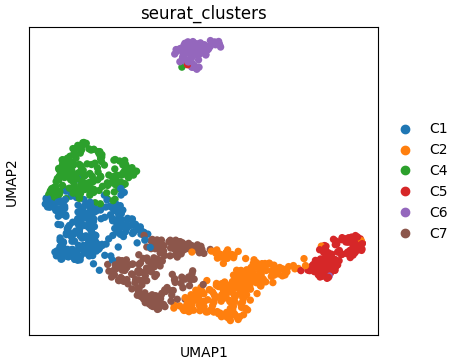

In [19]:
st_processed = process_anndata(st,neighbors=True,umap=True,n_comps=100)
sc.pl.umap(st_processed,color=['seurat_clusters'])

### RNA data

Processing RNA data...
Identifying highly variable genes...
Normalizing total counts...
Applying log1p transformation...
Saving pre-log1p counts to a layer...
Scaling the data...
Performing PCA...
Calculating neighbors based on cosine metric...
Performing UMAP...
Processing completed.


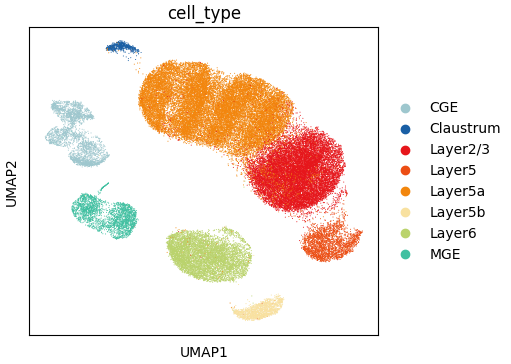

In [20]:
rna_processed = process_anndata(rna,neighbors=True,umap=True,n_comps=100)
sc.pl.umap(rna_processed,color=['cell_type'],palette=rna_col)

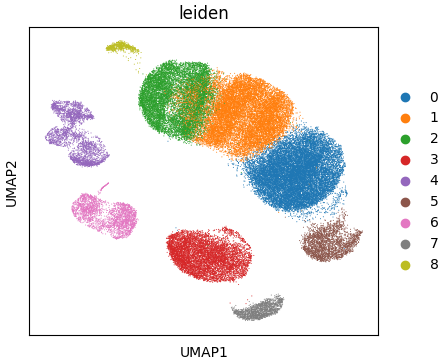

In [21]:
sc.tl.leiden(rna_processed,resolution=0.2)
sc.pl.umap(rna_processed,color=['leiden'])

### Methylation data

Processing RNA data...
Identifying highly variable genes...


/slurm/home/yrd/fanlab/yangpenghui/anaconda3/envs/simo/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


Applying log1p transformation...
Saving pre-log1p counts to a layer...
Scaling the data...
Performing PCA...
Calculating neighbors based on cosine metric...
Performing UMAP...
Processing completed.


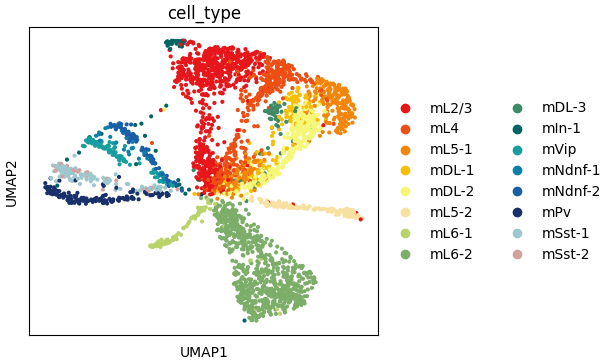

In [22]:
met.X = met.layers["norm"].copy()
met_processed = process_anndata(met,neighbors=True,umap=True,n_comps=100,normalize_total=False)
sc.pl.umap(met_processed,color=['cell_type'],palette=met_col)

### Methylation data (gene-cell)

Processing RNA data...
Identifying highly variable genes...


/slurm/home/yrd/fanlab/yangpenghui/anaconda3/envs/simo/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


Applying log1p transformation...
Saving pre-log1p counts to a layer...
Scaling the data...
Performing PCA...
Calculating neighbors based on cosine metric...
Performing UMAP...
Processing completed.


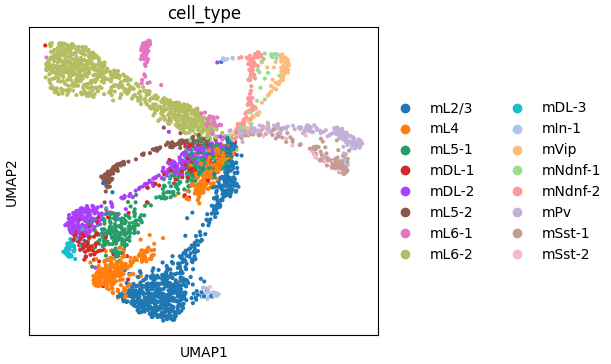

In [23]:
gmm_processed = process_anndata(gmm,neighbors=True,umap=True,n_comps=100,normalize_total=False)
sc.pl.umap(gmm_processed,color=['cell_type'])

### Save processed data

In [ ]:
rna_processed.obsm['reduction']=rna_processed.obsm['X_pca']
gmm_processed.obsm['reduction']=gmm_processed.obsm['X_pca']
met_processed.obsm['reduction']=met_processed.obsm['X_pca']
st_processed.obsm['reduction']=st_processed.obsm['X_pca']

# #rna_processed.__dict__['_raw'].__dict__['_var'] = rna_processed.__dict__['_raw'].__dict__['_var'].rename(columns={'_index': 'features'})
# #gmm_processed.__dict__['_raw'].__dict__['_var'] = gmm_processed.__dict__['_raw'].__dict__['_var'].rename(columns={'_index': 'features'})
# #met_processed.__dict__['_raw'].__dict__['_var'] = met_processed.__dict__['_raw'].__dict__['_var'].rename(columns={'_index': 'features'})
st_processed.__dict__['_raw'].__dict__['_var'] = st_processed.__dict__['_raw'].__dict__['_var'].rename(columns={'_index': 'features'})

rna_processed.write_h5ad(path+"/rna_processed.h5ad")
gmm_processed.write_h5ad(path+"/gmm_processed.h5ad")
met_processed.write_h5ad(path+"/met_processed.h5ad")
st_processed.write_h5ad(path+"/st_processed.h5ad")

### Load processed data

In [24]:
rna_processed = load_data(path + '/rna_processed.h5ad')
gmm_processed = load_data(path + '/gmm_processed.h5ad')
met_processed = load_data(path + '/met_processed.h5ad')
st_processed = load_data(path+"/st_processed.h5ad")

## Alignment of modality 1 (RNA)
SIMO disassembles the spatial integration of multiple modalities into an ordered mapping of a single modality. Due to the importance of transcriptome information and the necessity of shared modalities, we first perform spatial mapping of transcriptome data. Simply put, we use the optimal transport algorithm, combined with spatial/modal KNN graph, to calculate the mapping probability between a single cell in the scRNA-seq data and the ST spot, and obtain the matching relationship between cell-spots.
### Find DEGs
The retention of differential genes or hypervariable genes can reduce noise in the data.

In [30]:
gene_list1_params = {
    "gene_selection_method": 'deg',
    "deg_num": 100,
    "marker1_by": 'seurat_clusters',
    "marker2_by": 'cell_type',
}
gene_list1 = find_marker(st_processed, 
                         rna_processed, 
                         **gene_list1_params
                        )

Number of common genes: 21098


### Alignment (ST&scRNA-seq)
This step is a key step in modal data mapping, and the spot-cell matching relationship can be calculated. Since the input scRNA-seq data is large and considering the computational cost, here we use ```alignment_1_batch```. This ```alignment_1_batch``` will randomly divide the input scRNA-seq data and run it in batches, and finally splice it to obtain the complete result.

In [31]:
alignment_1_params = {
    "alpha": 0.1,
    "G_init": None,
    "p_distribution": None,
    "q_distribution": None,
    "aware_st_label": "seurat_clusters",
    "aware_sc_label": "cell_type",
}
out1 = alignment_1_batch(adata1=st_processed[:, gene_list1],
                   adata2=rna_processed[:, gene_list1],
                   **alignment_1_params)

Splitting dataset into 5 subsets...
Running alignment on subset 1/5...
Calculating dissimilarity using euclidean distance on scaled data...
Processing RNA data...
Identifying highly variable genes...
Normalizing total counts...
Applying log1p transformation...
Saving pre-log1p counts to a layer...
Scaling the data...
Processing completed.
Constructing connectivity...
k = 10
aware_st = True
aware power = 2
aware_sc = True
aware power = 2
Running OT...
alpha = 0.1
OT done!
Running alignment on subset 2/5...
Calculating dissimilarity using euclidean distance on scaled data...
Processing RNA data...
Identifying highly variable genes...
Normalizing total counts...
Applying log1p transformation...
Saving pre-log1p counts to a layer...
Scaling the data...
Processing completed.
Constructing connectivity...
k = 10
aware_st = True
aware power = 2
aware_sc = True
aware power = 2
Running OT...
alpha = 0.1
OT done!
Running alignment on subset 3/5...
Calculating dissimilarity using euclidean distanc

### Location adjustment (Mapped cells in scRNA-seq)
After assigning the cell to the spot, the cell will be initially assigned the corresponding coordinates of the spot and then corrected. Correction is based on transcriptome similarity between cells and surrounding spots. The user can specify the maximum number of cells allocated to each spot or the desired number.


In [33]:
assign_coord_1_params = {
    "non_zero_probabilities": True,
    "no_repeated_cells": True,
    "top_num": 5,
    "expected_num": None,
    "pos_random": False,
    "layer": 'data'
}

st_processed.obs['type']=st_processed.obs['seurat_clusters']
rna_processed.obs['type']=rna_processed.obs['leiden']

map1 = assign_coord_1(adata1=st_processed[:, gene_list1], 
                      adata2=rna_processed[:, gene_list1], 
                      out_data=out1,
                      **assign_coord_1_params)

Assigning spatial coordinates to cells...
random = False
Maximum number of cells assigned to spots: 5
There are 1075 spots and 1075 of them were assigned cells.
Assignment done!


In [34]:
rna_mapped = rna_processed[map1.cell]
rna_mapped.obsm['spatial'] = map1[['Cell_xcoord','Cell_ycoord']].values
rna_mapped.obs['spot'] = map1['spot'].tolist()
rna_mapped.obs['spot_type'] = map1['spot_type'].tolist()
# rna_mapped.write_h5ad(path+"/rna_mapped.h5ad")

SIMO contains a wealth of drawing functions to meet users' needs for drawing images during calculations, including spatial maps of cells, highlight maps of cell types, and spatial maps of expression intensity.

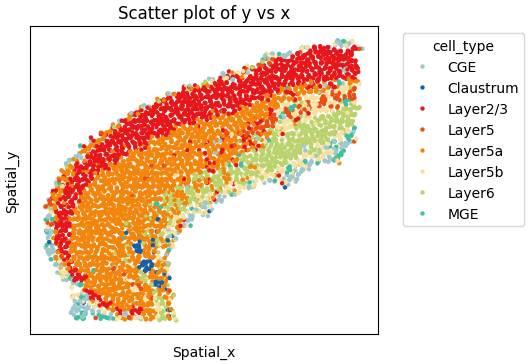

In [35]:
sdplot(rna_mapped,color_col='cell_type',size=10,palette=rna_col) 

Plot saved to /slurm/home/yrd/fanlab/yangpenghui/SIMO/data/mouse_brain/plot/SD_RNA_highlight.pdf


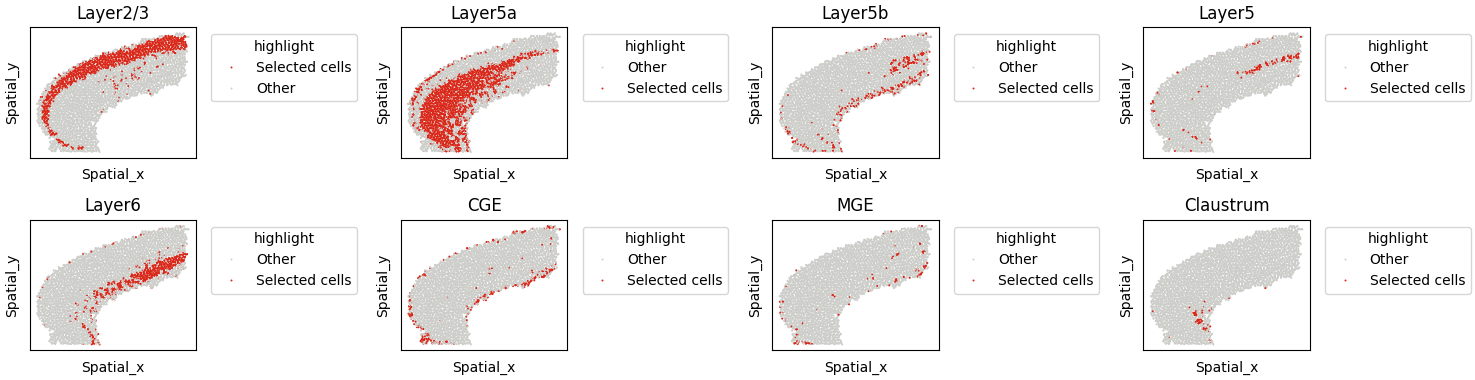

In [36]:
highlight_list = ['Layer2/3','Layer5a', 'Layer5b', 'Layer5', 'Layer6', 'CGE', 'MGE', 'Claustrum']
sdplot(rna_mapped,
           color_col='cell_type',
           highlight=highlight_list,
           size=2,
           marker='o',
           rotation_angle=-90,
           show_ticks=False,
           x_label='Spatial_x',
           y_label='Spatial_y',
           palette='Set1',
           show=True,
           ncols=4,
           set_equal=False,figsize=(15,4))

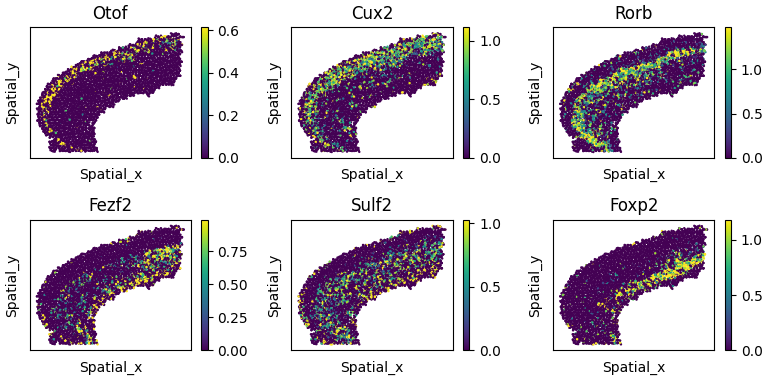

In [3]:
genes_list = ['Otof','Cux2','Rorb','Fezf2','Sulf2','Foxp2']
sfplot(rna_mapped,features=genes_list,size=3,rotation_angle=-90,ncols=3,figsize=(8,4),
       max_cutoff='q95',min_cutoff='q5')

## Alignment of modality 2 (MET)
The second modality is directly mapped or matched with spatially resolved scRNA-seq data that has already been obtained. Subsequently, the cells from the second modality are propagated to spots, thus achieving the calculation of spot-cell associations for the second modality.

### Find degs

In [12]:
gene_list2_params = {
    "gene_selection_method": 'deg',
    "marker1_by": "leiden",  
    "marker2_by": "cell_type",  
}
gene_list2 = find_marker(rna_mapped, 
                         gmm_processed, 
                         **gene_list2_params)

Number of common genes: 24505


### Alignment (scRNA-seq&snmC-seq)
Due to the often inverse relationship between gene expression and DNA methylation in biological signal intensity, here we choose modality2_type as negative, indicating a negative correlation between the integrated modalities.

In [13]:
alignment_2_params = {
    "reg": 1,
    "cutoff": 0,
    "layer": None,
    "transfer_obs1": None,
    "transfer_obs2": None,
    "adata1_avg_by": 'leiden',
    "adata2_avg_by": 'cell_type',
    "modality2_type": 'neg',
    "reverse": False
}

out2,transfer_df,obs_df1,obs_df2 = alignment_2(adata1=rna_mapped[:, gene_list2].copy(), 
                                               adata2=gmm_processed[:, gene_list2].copy(), 
                                               coor_df=map1,
                                               **alignment_2_params)

Performing label transfer...
Calculating average expression...
Computing correlation matrix...
Performing unbalanced optimal transport...
Applying cutoff to transfer probabilities and mapping labels...
Label transfer completed.
Processing cell type 1/9: mL2/3
Processing cell type 2/9: mL4
Processing cell type 3/9: mDL-2
Processing cell type 4/9: mNdnf-2
Processing cell type 5/9: mL6-1
Processing cell type 6/9: mL5-2
Processing cell type 7/9: mL6-2
Processing cell type 8/9: mPv
Processing cell type 9/9: mDL-3


In [14]:
rna_mapped.obs['annotation'] = obs_df1['annotation'].tolist()
met_processed.obs['annotation'] = obs_df2['annotation'].tolist()

### Location adjustment (Mapped cells in snmC-seq)
Here, the correction of cell coordinates is computed based on the cosine similarity of low-dimensional embeddings of the modalities.

In [16]:
st_processed

AnnData object with n_obs × n_vars = 1075 × 31053
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'seurat_clusters'
    var: 'features', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'neighbors', 'pca', 'seurat_clusters_colors', 'umap'
    obsm: 'X_pca', 'X_umap', 'reduction', 'spatial'
    varm: 'PCs'
    layers: 'counts', 'data'
    obsp: 'connectivities', 'distances'

In [17]:
assign_coord_2_params = {
    "non_zero_probabilities": True,
    "no_repeated_cells": True,
    "top_num": 3,
    "pos_random": False
}
st_processed.obs['type']=st_processed.obs['seurat_clusters']
met_processed.obs['type']=met_processed.obs['cell_type']
map2 = assign_coord_2(adata1=st_processed, 
                      adata2=met_processed, 
                      out_data=out2,
                      **assign_coord_2_params)

Assigning spatial coordinates to cells...
random = False
Maximum number of cells assigned to spots: 3
There are 1075 spots and 962 of them were assigned cells.
Assignment done!


In [18]:
met_mapped = met_processed[map2.cell.tolist()]
met_mapped.obsm['spatial'] = map2[['Cell_xcoord','Cell_ycoord']].values
met_mapped.obs['spot'] = map2['spot'].tolist()
met_mapped.obs['spot_type'] = map2['spot_type'].tolist()
# met_mapped.write_h5ad(path+"/met_mapped.h5ad")

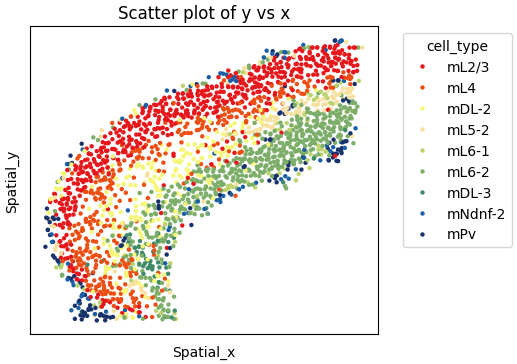

In [21]:
sdplot(met_mapped,color_col='cell_type',size=10,palette=met_col) 

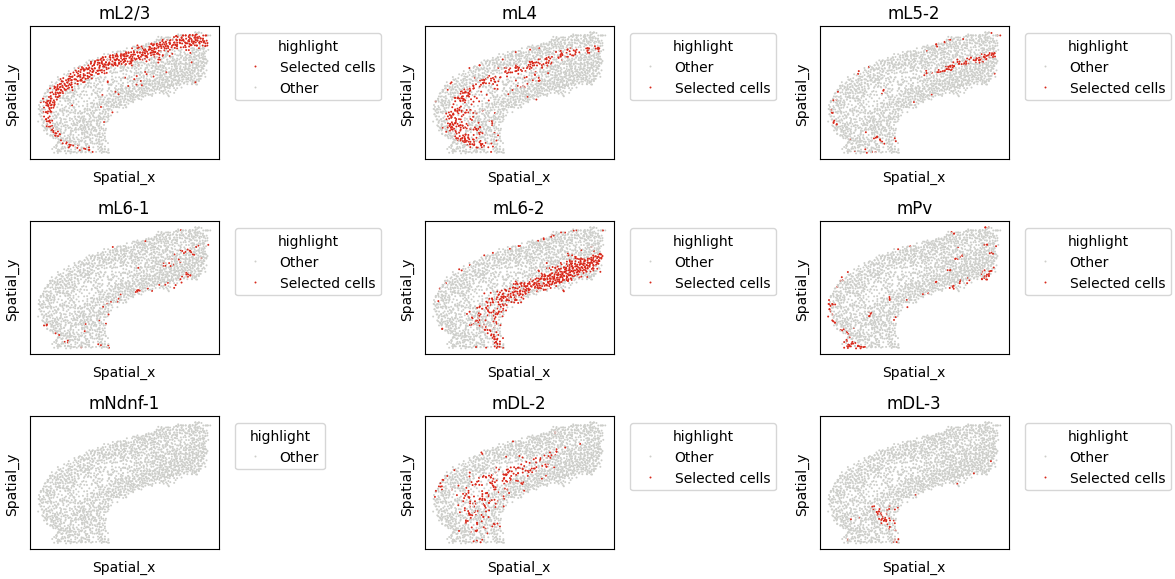

In [22]:
highlight_list = ['mL2/3', 'mL4', 'mL5-2','mL6-1', 'mL6-2', 'mPv', 'mNdnf-1', 'mDL-2', 'mDL-3']
sdplot(met_mapped,
           color_col='cell_type',
           highlight=highlight_list,
           size=2,
           marker='o',
           rotation_angle=-90,
           show_ticks=False,
           x_label='Spatial_x',
           y_label='Spatial_y',
           palette='Set1',
           show=True,
           ncols=3,
           set_equal=False,figsize=(12,6))


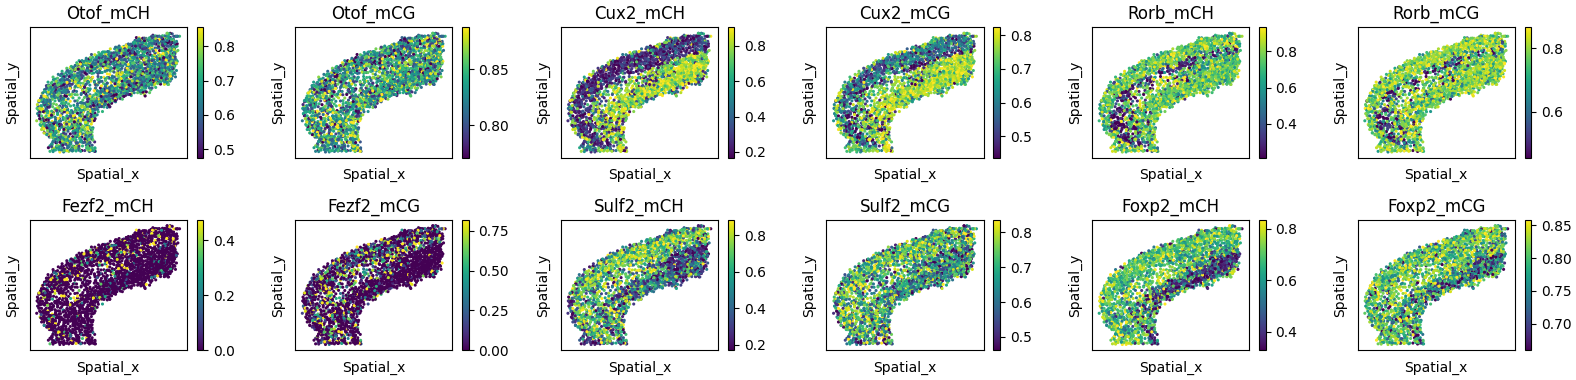

In [23]:
genes_list = ['Otof_mCH','Otof_mCG','Cux2_mCH','Cux2_mCG','Rorb_mCH','Rorb_mCG','Fezf2_mCH','Fezf2_mCG','Sulf2_mCH','Sulf2_mCG','Foxp2_mCH','Foxp2_mCG']
nrows = 2
ncols = 6
width = 16
high = 4

sfplot(met_mapped,features=genes_list,size=5,rotation_angle=-90,figsize=(16,4),ncols=6,
       max_cutoff='q95',min_cutoff='q5')

## Regulation analysis
Based on the fold change of different modal cluster-based signals, we used the correlation between the two to conduct multi-modal regulation analysis to explore the regulatory relationship between different modalities.

In [24]:
feature_transfer_df = pd.DataFrame({
    'feature1': met_processed.var['gene_name'],
    'feature2': met_processed.var.index.tolist(),
    'combos': met_processed.var['gene_name'].astype('str') + '::' + met_processed.var.index.tolist()
})
np.random.seed(1234)
final_result = regulation_analysis(rna_mapped, 
                                   met_mapped, 
                                   marker1_by='annotation',
                                   marker2_by='annotation',
                                   layer1='data',
                                   layer2='data',
                                   method='wilcoxon',
                                   feature_transfer_df=feature_transfer_df, 
                                   deg_pval_threshold=0.05)

Processing: 100%|██████████| 6938/6938 [01:33<00:00, 73.83it/s]


In [25]:
met_order = [
    "mL2/3", "mL4", "mL5-1", "mDL-1", "mDL-2", "mL5-2",
    "mL6-1", "mL6-2", "mDL-3", "mIn-1", "mVip",
    "mNdnf-1", "mNdnf-2", "mPv", "mSst-1", "mSst-2"
]
final_result['group'] = pd.Categorical(final_result['group'], categories=met_order)

sig_df = final_result[final_result['pearson_pvalue'] < 0.05]
sig_df['mode'] = sig_df['pearson_correlation'].apply(lambda x: 'pos' if x > 0 else 'neg')
neg_df = final_result[(final_result['pearson_pvalue'] < 0.05) & (final_result['pearson_correlation'] < 0)]
pos_df = final_result[(final_result['pearson_pvalue'] < 0.05) & (final_result['pearson_correlation'] > 0)]

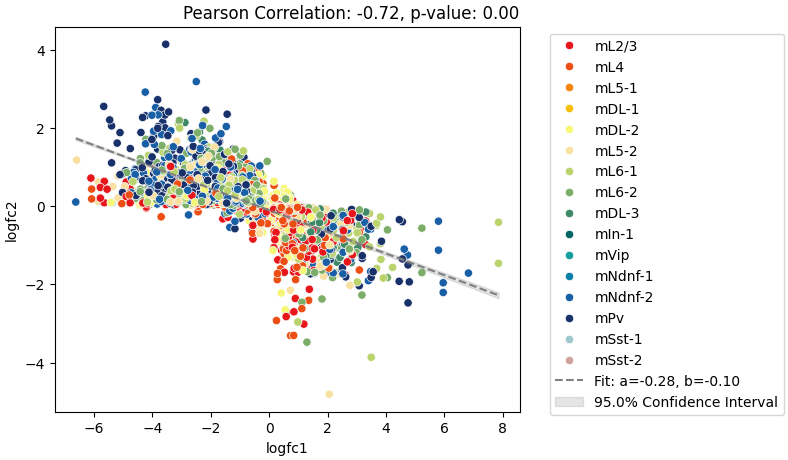

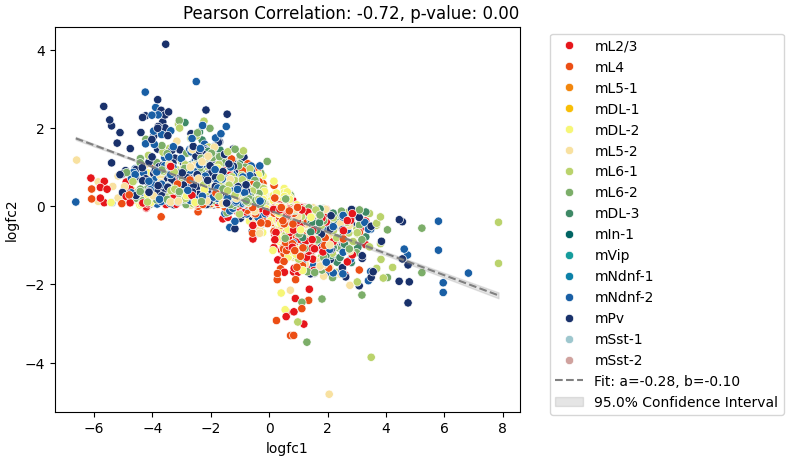

In [26]:
cor_plot(sig_df['logfc1'], sig_df['logfc2'], sig_df['group'], palette=met_col, fit_color='grey', fit_linestyle='--',figsize=(6, 5),show=True)
cor_plot(neg_df['logfc1'], neg_df['logfc2'], neg_df['group'], palette=met_col, fit_color='grey', fit_linestyle='--',figsize=(6, 5),show=True)

## Spatial regulation analysis (Selected L5a)
The signals of the two modalities are divided as a regulation score, and then the feature modules with specific distribution in the space are calculated. The results reflect the spatial regulatory heterogeneity of cells.

In [32]:
selected_met = [ "mL4", "mDL-2"]
selected_rna = ['Layer5a']
selected_spot_types = ['C1', 'C4', 'C7']

rna_mapped_sub = rna_mapped[rna_mapped.obs['cell_type'].isin(selected_rna)&
                           rna_mapped.obs['spot_type'].isin(selected_spot_types) ]
met_mapped_sub = met_mapped[met_mapped.obs['annotation'].isin(selected_met)&
                           met_mapped.obs['spot_type'].isin(selected_spot_types) ]

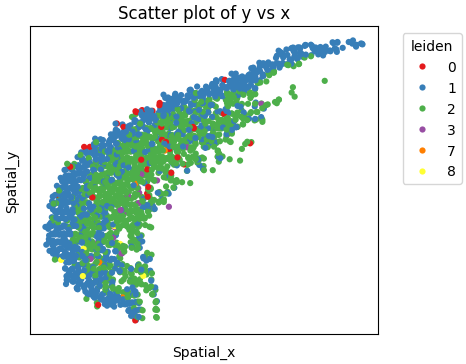

In [33]:
sdplot(rna_mapped_sub,color_col='leiden',size=20) 

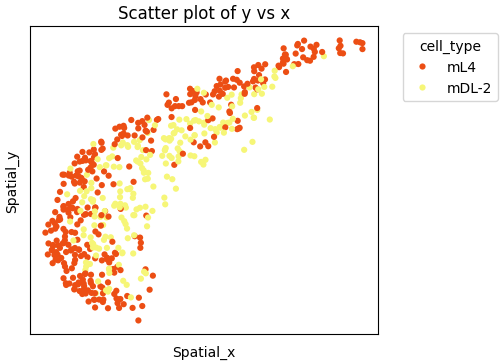

In [34]:
sdplot(met_mapped_sub,color_col='cell_type',size=20,palette=met_col) 

In [29]:
# st_pos = extract_reduction(st_processed,use_rep='spatial',column_names=['x','y'])
# k = 6
# nbrs = NearestNeighbors(n_neighbors=k+1).fit(st_pos.dropna())
# distances, indices = nbrs.kneighbors(st_pos.dropna())
# kNN_dist = distances[:, -1]
# sigma = int(np.median(kNN_dist))
np.random.seed(1234)
sr_out =  spatial_regulation(rna_mapped_sub, 
                           met_mapped_sub,
                           sig_df,
                           feature_transfer_df=feature_transfer_df, 
                           layer1='data',
                           layer2='data',
                           smooth_k=10,
                           sigma=140, 
                           correlation='pearson',
                           epsilon=1e-3,
                           minK=2,
                           maxK=8,
                           rep=20,
                           resample_proportion=0.5,
                           cc_k=8,
                           avg_con_min=0.5,
                           avg_cor_min=0.5,
                           min_feature=20,
                           max_feature=200
                          )

sr_out['cc'].module = (sr_out['cc'].module.astype(int) + 1).astype(str)

Starting spatial regulation analysis...
Processing spatial regulation...


Processing: 100%|██████████| 876/876 [00:00<00:00, 2614.93it/s]


Clustering feautres...
Filtering feautres...
0  
1  


SIMO has a wealth of mapping functions for the results of regulatory analysis, including visualizing the module status, viewing the signal strength of the module, calculating scores based on the module and viewing the spatial distribution or group intensity.

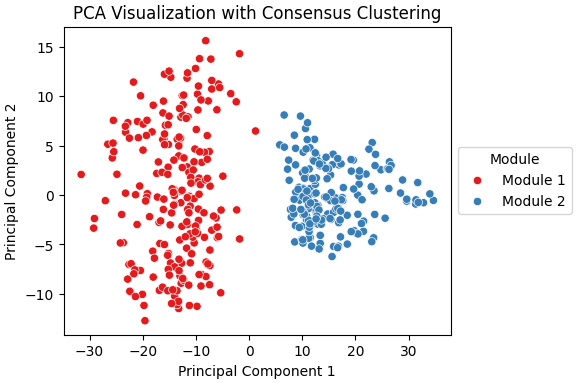

In [35]:
module_pca_plot(sr_out,palette='Set1')

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 21.344444444444445 mm


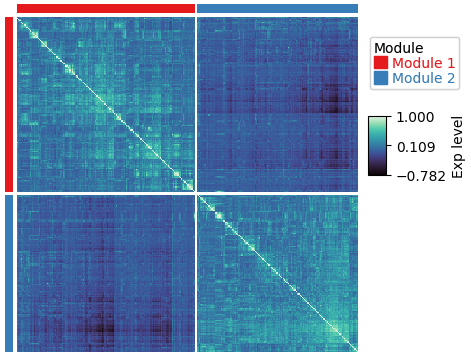

In [36]:
module_heatmap_plot(sr_out,module_name=['1','2'],figsize=(4.6,4))

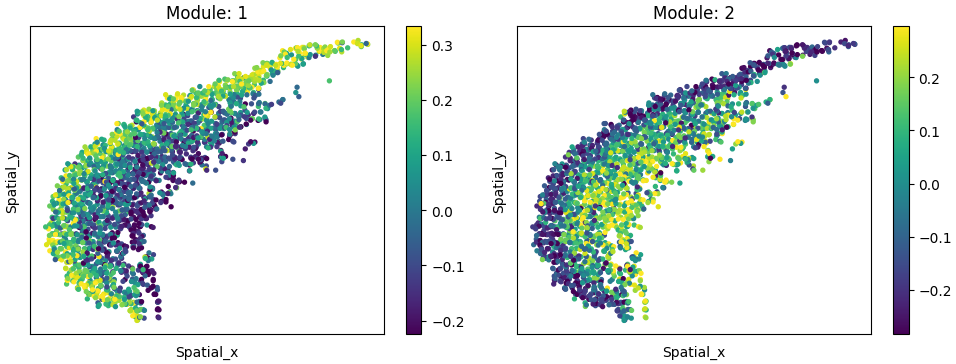

In [37]:
module_spatial_plot(rna_mapped_sub,
                    sr_out,
                    module_name=["1","2"],
                    feature_name="feature1",
                    use_raw=False,
                    figsize=(6,4),size=8,min_cutoff=['q5','q5'],max_cutoff=['q95','q95'])

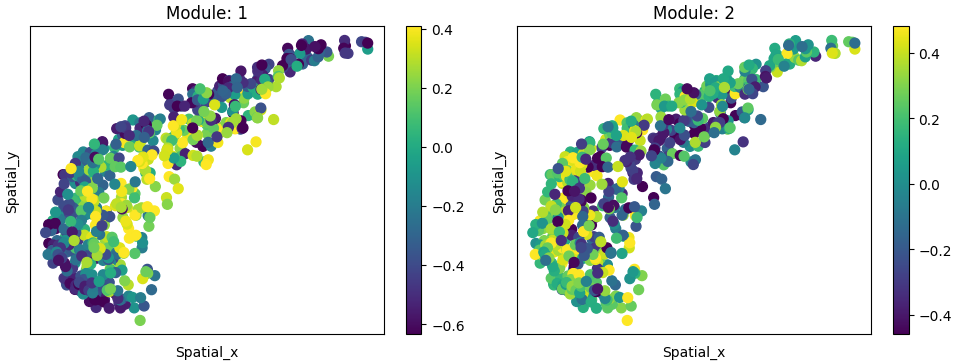

In [38]:
module_spatial_plot(met_mapped_sub,
                    sr_out,
                    module_name=["1","2"],
                    feature_name="feature2",
                    use_raw=False,
                    figsize=(6,4),size=50,min_cutoff=['q5','q5'],max_cutoff=['q95','q95'])

In [39]:
selected_cell_types = ['Layer2/3', 'Layer5a', 'Layer5b','Layer5', 'Layer6']
filtered_rna_mapped = rna_mapped[rna_mapped.obs['cell_type'].isin(selected_cell_types)]
filtered_rna_mapped.obs["cell_type"].cat.set_categories(selected_cell_types, inplace=True)

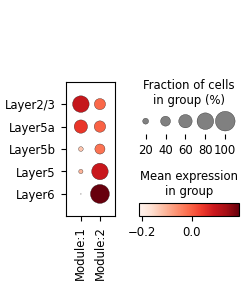

In [40]:
module_dot_plot(filtered_rna_mapped,
                    sr_out,
                    module_name=["1","2"],
                    feature_name="feature1",
                   use_raw=False,
                   show=True)

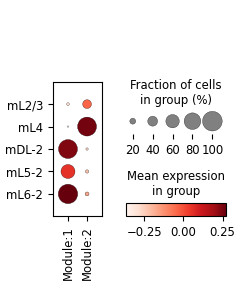

In [41]:
selected_cell_types = [ "mL2/3", "mL4", "mDL-2", "mL5-2", "mL6-2"]
filtered_met_mapped = met_mapped[met_mapped.obs['cell_type'].isin(selected_cell_types)]
filtered_met_mapped.obs["cell_type"].cat.set_categories(selected_cell_types, inplace=True)
module_dot_plot(filtered_met_mapped,
                    sr_out,
                    module_name=["1","2"],
                    feature_name="feature2",
                   use_raw=False)

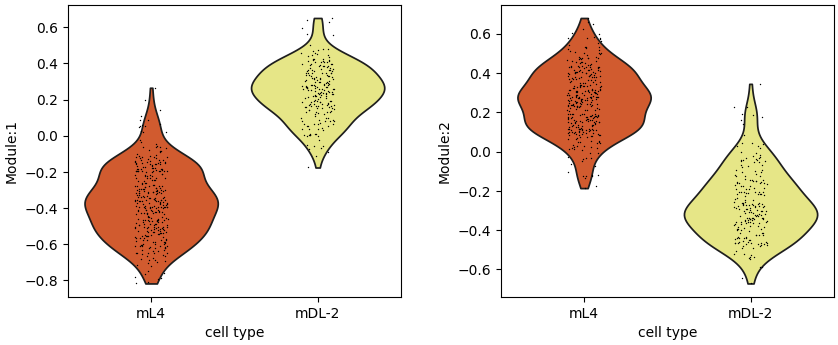

In [42]:
module_vilolin_plot(met_mapped_sub,
                    sr_out,
                    module_name=["1","2"],
                    feature_name="feature2",
                   use_raw=False,palette=met_col)

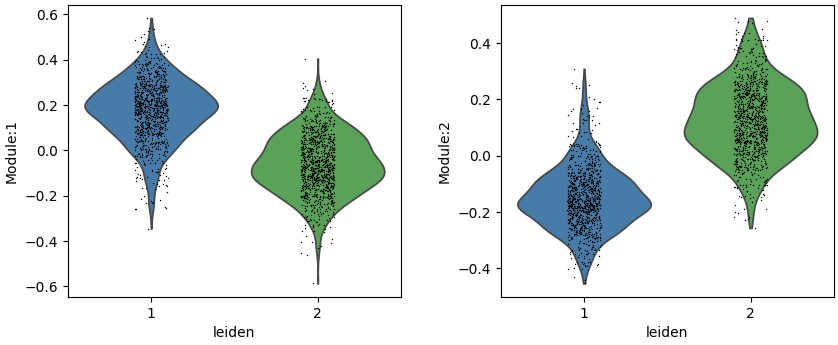

In [43]:
rna_mapped_sub_cluster = rna_mapped_sub[rna_mapped_sub.obs['leiden'].isin(['2','1'])]
module_vilolin_plot(rna_mapped_sub_cluster,
                    sr_out,
                    module_name=["1","2"],
                    feature_name="feature1",
                    groupby='leiden',
                    palette=[plt.get_cmap('Set1').colors[1],plt.get_cmap('Set1').colors[2]],
                   use_raw=False)

## 3D plot

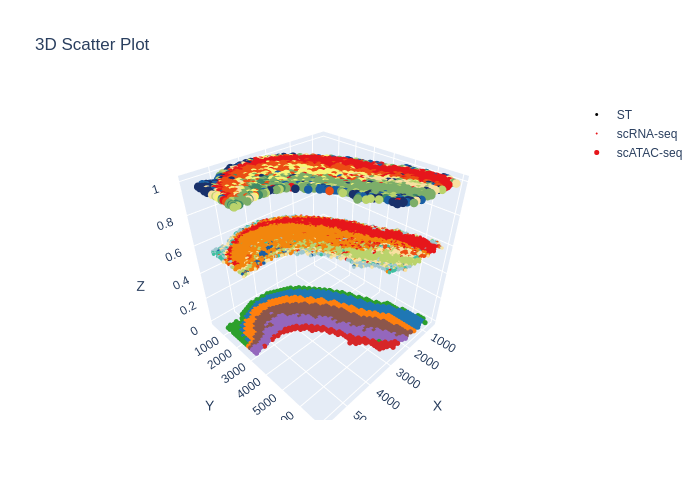

In [4]:
met_col = {
    "mL2/3": "#E6161B",
    "mL4": "#EC4E14",
    "mL5-1": "#F2860D",
    "mDL-1": "#F8BE06",
    "mDL-2": "#F6F677",
    "mL5-2": "#f8e1a0",
    "mL6-1": "#BAD36C",
    "mL6-2": "#7CAE69",
    "mDL-3": "#3E8966",
    "mIn-1": "#006463",
    "mVip": "#169D9D",
    "mNdnf-1": "#0C81A8",
    "mNdnf-2": "#195FA5",
    "mPv": "#19316B",
    "mSst-1": "#9EC7CE",
    "mSst-2": "#D0A29E"
}


rna_col = {
    "Layer2/3": "#E6161B",
    "Layer5": "#EC4E14",
    "Layer5a": "#F2860D",
    "Layer5b": "#f8e1a0",
    "Layer6": "#BAD36C",
    "CGE": "#9EC7CE",
    'MGE':"#40C0A1",
    "Claustrum": "#195FA5"
}

st_processed = load_data(path+"/st_processed.h5ad")
rna_mapped = load_data(path+"/rna_mapped.h5ad")
met_mapped = load_data(path+"/met_mapped.h5ad")

leiden_unique = st_processed.obs['seurat_clusters'].unique().tolist()
st_colors = plt.get_cmap('tab10').colors
st_col = {label: color for label, color in zip(leiden_unique, st_colors)}

plot_3d(anndatas = [st_processed,rna_mapped,met_mapped],
                      color_cols = ['seurat_clusters','cell_type','cell_type'],
                      titles = ['ST','scRNA-seq','scATAC-seq'],
                       color_palettes=[st_col,rna_col,met_col],sizes=[3, 2, 5], zs=[0, 0.6, 1],
                      save_path='mouse_brain.html')
